<a href="https://colab.research.google.com/github/Odima-dev/Data-Science-and-Machine-Learning/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import numpy as np

class ScratchSVMClassifier():
    """
    Scratch implementation of SVM classifier

    Parameters
    ----------
    num_iter : int
      Number of iterations
    lr : float
      Learning rate
    kernel : str
      Kernel type. Linear kernel (linear) or polynomial kernel (polly)
    threshold : float
      Threshold for choosing a support vector
    verbose : bool
      True to output the learning process

    Attributes
    ----------
    self.n_support_vectors : int
      Number of support vectors
    self.index_support_vectors : The following form of ndarray, shape (n_support_vectors,)
      Support vector index
    self.X_sv :  The following forms of ndarray, shape (n_support_vectors, n_features)
      Support vector features
    self.lam_sv :  The following forms of ndarray, shape (n_support_vectors, 1)
      Support vector undetermined multiplier
    self.y_sv :  The following forms of ndarray, shape (n_support_vectors, 1)
      Support vector label
    """

    def __init__(self, num_iter=1000, lr=0.001, kernel='linear', threshold=1e-5, verbose=False,
                 gamma=1, theta0=0, degree=2):
        """
        Initialize the classifier.
        """
        self.num_iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose

        # For polynomial kernel:
        self.gamma = gamma
        self.theta0 = theta0
        self.degree = degree

    def _kernel(self, x1, x2):
        """
        Kernel function.
        """
        if self.kernel == 'linear':
            return np.dot(x1, x2)
        elif self.kernel == 'polly':
            return (self.gamma * np.dot(x1, x2) + self.theta0) ** self.degree
        else:
            raise ValueError("Unsupported kernel type")

    def fit(self, X, y):
        """
        Learn the SVM classifier. If verification data is input, the accuracy for it is also calculated for each iteration.

        Parameters
        ----------
        X : of the following form. ndarray, shape (n_samples, n_features)
            Features of training data
        y : The following form of ndarray, shape (n_samples,)
            Correct answer value of training data
        X_val : of the following form. ndarray, shape (n_samples, n_features)
            Features of verification data
        y_val : The following form of ndarray, shape (n_samples,)
            Correct value of verification data
        """
        n_samples, n_features = X.shape

        # Ensuring labels are -1 or 1
        y = y.copy()
        y[y == 0] = -1
        y = y.reshape(-1, 1)  # column vector

        # Initializing multipliers
        self.lam = np.zeros((n_samples, 1))

        for it in range(self.num_iter):
            for i in range(n_samples):
                # Computing gradient part
                sum_term = 0
                for j in range(n_samples):
                    sum_term += self.lam[j] * y[j] * y[i] * self._kernel(X[i], X[j])

                # problem 1:Lagrange’s steepest descent by the undetermined multiplier method

                self.lam[i] += self.lr * (1 - sum_term)
                # Enforce constraint λ ≥ 0
                if self.lam[i] < 0:
                    self.lam[i] = 0

            if self.verbose and (it % 100 == 0 or it == self.num_iter - 1):
                print(f"Iteration {it+1}/{self.num_iter}")

        # Problem 2: Support vector determination
        self.index_support_vectors = np.where(self.lam > self.threshold)[0]
        self.n_support_vectors = len(self.index_support_vectors)
        self.X_sv = X[self.index_support_vectors]
        self.lam_sv = self.lam[self.index_support_vectors]
        self.y_sv = y[self.index_support_vectors]

        if self.verbose:
            print(f"Number of support vectors: {self.n_support_vectors}")

    # problem 3:Estimated
    def predict(self, X):
        """
        Estimate the label using the SVM classifier.

        Parameters
        ----------
        X : of the following form. ndarray, shape (n_samples, n_features)
            sample

        Returns
        -------
            The following form of ndarray, shape (n_samples, 1)
            Estimated result by SVM classifier
        """
        y_pred = []
        for x in X:
            f_x = 0
            for lam_n, y_n, s_n in zip(self.lam_sv, self.y_sv, self.X_sv):
                f_x += lam_n * y_n * self._kernel(x, s_n)
            y_pred.append(np.sign(f_x))
        return np.array(y_pred).flatten()


In [25]:
# Problem 4: Learning and estimation

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.svm import SVC

# Generating binary dataset
X, y = make_blobs(n_samples=100, centers=2, cluster_std=1.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Training scratch SVM
scratch_svm = ScratchSVMClassifier(num_iter=500, lr=0.001, kernel='linear', verbose=True)
scratch_svm.fit(X_train, y_train)
y_pred = scratch_svm.predict(X_test)

y_pred = np.where(y_pred == -1, 0, 1)

print("\nScratch SVM Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

# Comparing with sklearn
sklearn_svm = SVC(kernel='linear', C=1e6)
sklearn_svm.fit(X_train, y_train)
y_pred_sklearn = sklearn_svm.predict(X_test)

print("\nsklearn SVM Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_sklearn))
print("Precision:", precision_score(y_test, y_pred_sklearn))
print("Recall:", recall_score(y_test, y_pred_sklearn))


Iteration 1/500
Iteration 101/500
Iteration 201/500
Iteration 301/500
Iteration 401/500
Iteration 500/500
Number of support vectors: 4

Scratch SVM Results:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0

sklearn SVM Results:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0


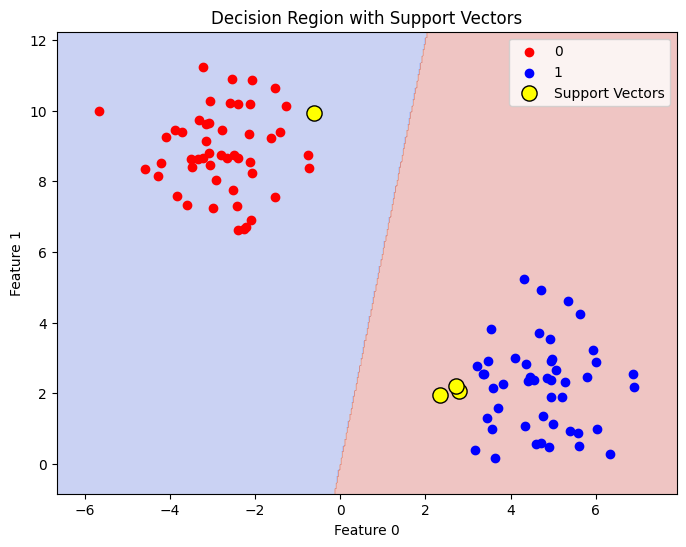

In [26]:
# Problem 5: Visualization of decision area

import matplotlib.pyplot as plt
import numpy as np

# Creatig the grid to cover data
xx, yy = np.meshgrid(
    np.linspace(X[:, 0].min()-1, X[:, 0].max()+1, 500),
    np.linspace(X[:, 1].min()-1, X[:, 1].max()+1, 500)
)
grid = np.c_[xx.ravel(), yy.ravel()]

# Predicting over the grid
Z = scratch_svm.predict(grid)
Z = np.where(Z == -1, 0, 1)  # match original labels
Z = Z.reshape(xx.shape)

# Plotting the decision region
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

# Plotting data points
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='0')
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='1')

# Plotting the support vectors in yellow color
sv = scratch_svm.X_sv
plt.scatter(sv[:, 0], sv[:, 1], s=120, facecolors='yellow', edgecolors='k', label='Support Vectors')

plt.title("Decision Region with Support Vectors")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend()
plt.show()


Iteration 1/500
Iteration 101/500
Iteration 201/500
Iteration 301/500
Iteration 401/500
Iteration 500/500
Number of support vectors: 7

Scratch SVM (Polynomial Kernel) Results:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0


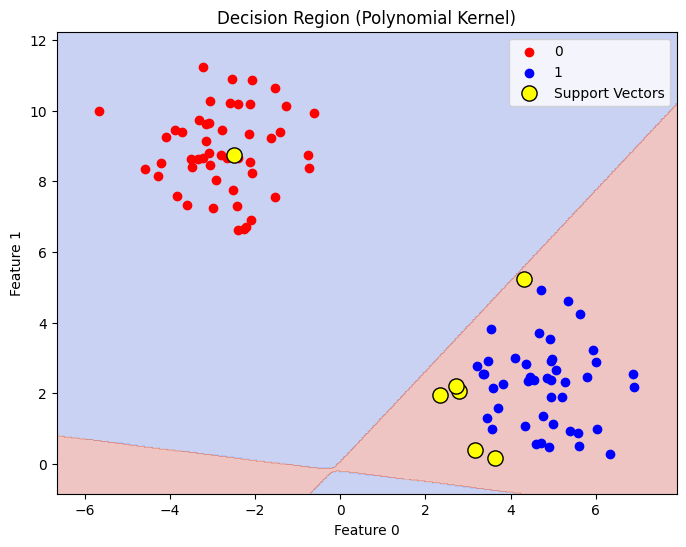

In [29]:
# problem 6:(Advance task) Creation of polynomial kernel function

# Creating new scratch SVM with polynomial kernel
scratch_svm_poly = ScratchSVMClassifier(
    num_iter=500,
    lr=0.001,
    kernel='polly',
    gamma=1,     # hyperparameter γ
    theta0=1,    # hyperparameter θ₀
    degree=2,    # degree d
    verbose=True
)

# Training it
scratch_svm_poly.fit(X_train, y_train)

# Predicting and converting labels for metric comparison
y_pred_poly = scratch_svm_poly.predict(X_test)
y_pred_poly = np.where(y_pred_poly == -1, 0, 1)

print("\nScratch SVM (Polynomial Kernel) Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_poly))
print("Precision:", precision_score(y_test, y_pred_poly))
print("Recall:", recall_score(y_test, y_pred_poly))

# Visualizing decision region for polynomial kernel
xx, yy = np.meshgrid(
    np.linspace(X[:, 0].min()-1, X[:, 0].max()+1, 500),
    np.linspace(X[:, 1].min()-1, X[:, 1].max()+1, 500)
)
grid = np.c_[xx.ravel(), yy.ravel()]
Z = scratch_svm_poly.predict(grid)
Z = np.where(Z == -1, 0, 1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='0')
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='1')
sv = scratch_svm_poly.X_sv
plt.scatter(sv[:, 0], sv[:, 1], s=120, facecolors='yellow', edgecolors='k', label='Support Vectors')
plt.title("Decision Region (Polynomial Kernel)")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend()
plt.show()
